In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense

/Users/gadamico/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/gadamico/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/gadamico/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/gadamico/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/gadamico/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: Runt

In [87]:
ca = pd.read_csv('california_raw.csv')
ri = pd.read_csv('rhode_island_raw.csv')

# Californian Hepatitis

In [31]:
y = ca['mx']

In [88]:
ca = ca.drop(columns = ['Unnamed: 0', 'County_x', 'County_y'])

In [89]:
ca['Per capita income'] = ca['Per capita income'].map(lambda x: int(str(x).replace('$', '').replace(',', '')))

ca['Median household income'] = ca['Median household income'].map(lambda x: int(str(x).replace('$', '').replace(',', '')))

ca['Median family income'] = ca['Median family income'].map(lambda x: int(str(x).replace('$', '').replace(',', '')))

In [90]:
ca = ca.rename({'Rank': 'Pop_Rank'}, axis = 1)

In [91]:
sex_dums = pd.get_dummies(ca['sex'])
ca = pd.concat([ca, sex_dums], axis = 1)

ca = ca.drop(columns = ['sex'])

In [92]:
ca['Population'] = ca['Population'].map(lambda x: int(x.replace(',', '')))

In [93]:
ca = ca.rename({'Population density ': 'Population density'}, axis = 1)

In [94]:
ca['Population density'] = ca['Population density'].map(lambda x: float(str(x).replace(',', '')))

## Linear Regression

In [40]:
indices = ca.loc[ca['year_id'] < 2006].index
ca2 = ca.drop(indices)

In [41]:
test_columns = [col for col in ca2.columns if (col not in ['location_name', 'lower', 'upper',
                                                           'mx', 'Climate', 'County'])]
X = ca2[test_columns]
y = ca2['mx']

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [43]:
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

In [44]:
lr = LinearRegression().fit(X_train_scaled, y_train)

In [45]:
lr.score(X_test_scaled, y_test)

0.7953014174137094

## Random Forest

In [46]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.8904438487216854

### GridSearching
Let's see if we can't bump this up a little bit.

In [62]:
forest_params = {
    'n_estimators': [8, 6],
    'max_depth': [None, 1, 2],
    'min_samples_leaf': [1, 2],
    'min_samples_split': [3, 4]
}
gs = GridSearchCV(estimator = rf, param_grid = forest_params)
gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9115640927941838
{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 8}


## Exploring Correlations

In [95]:
ca.drop(columns = [col for col in ca.columns if ('County' in col) | ('.1' in col)]).corr()['mx'].nlargest(10)

mx                          1.000000
upper                       0.997140
lower                       0.996790
Male                        0.319587
SanFrancisco                0.145026
Population density          0.136621
Stanislaus                  0.099362
Cold semi-arid              0.090626
Hot-summer mediterranean    0.079101
Kings                       0.075531
Name: mx, dtype: float64

In [96]:
ca.drop(columns = [col for col in ca.columns if ('County' in col) | ('.1' in col)]).corr()['mx'].nsmallest(10)

Female                                           -0.313493
Median family income                             -0.123207
Median household income                          -0.106358
Pop_Rank                                         -0.102566
Per capita income                                -0.091923
Mono                                             -0.078444
Alpine                                           -0.076026
Dry-summer subarctic/Cold-summer mediterranean   -0.076026
Cold-summer mediterranean                        -0.070921
Sierra                                           -0.059661
Name: mx, dtype: float64

The biggest factor here seems to be sex. Being male is correlated positively and being female negatively with hepatitis mortality in California. The climatic zones show up marginally. It may be worth exploring these further.

In [97]:
# Let's look at all the counties any _part_ of which is in the relevant climatic zones.
ca['SA'] = ca['Climate'].apply(lambda x: int('Cold semi-arid' in x))

I've got some reduplication in my columns, so I'll remove that in the upcoming searches.

In [99]:
ca.drop(columns = [col for col in ca.columns if ('County' in col) | ('.1' in col)]).corr()['mx'].nlargest(10)

mx                          1.000000
upper                       0.997140
lower                       0.996790
Male                        0.319587
SanFrancisco                0.145026
Population density          0.136621
Stanislaus                  0.099362
Cold semi-arid              0.090626
Hot-summer mediterranean    0.079101
Kings                       0.075531
Name: mx, dtype: float64

In [100]:
ca['HSM'] = ca['Climate'].apply(lambda x: int('Hot-summer mediterranean' in x))

In [101]:
ca.drop(columns = [col for col in ca.columns if ('County' in col) | ('.1' in col)]).corr()['mx'].nlargest(10)

mx                          1.000000
upper                       0.997140
lower                       0.996790
Male                        0.319587
SanFrancisco                0.145026
Population density          0.136621
Stanislaus                  0.099362
Cold semi-arid              0.090626
Hot-summer mediterranean    0.079101
Kings                       0.075531
Name: mx, dtype: float64

In [102]:
ca['DSS'] = ca['Climate'].apply(lambda x: int('Dry-summer subarctic' in x))

In [103]:
ca.drop(columns = [col for col in ca.columns if ('County' in col) | ('.1' in col)]).corr()['mx'].nsmallest(10)

Female                                           -0.313493
Median family income                             -0.123207
Median household income                          -0.106358
Pop_Rank                                         -0.102566
Per capita income                                -0.091923
Mono                                             -0.078444
Alpine                                           -0.076026
Dry-summer subarctic/Cold-summer mediterranean   -0.076026
Cold-summer mediterranean                        -0.070921
Sierra                                           -0.059661
Name: mx, dtype: float64

In [104]:
ca['CSM'] = ca['Climate'].apply(lambda x: int('Cold-summer mediterranean' in x))

In [105]:
ca.corr()['mx'].nsmallest(10)

Female                                           -0.313493
CSM                                              -0.136411
Median family income                             -0.123207
Median household income                          -0.106358
Pop_Rank                                         -0.102566
Per capita income                                -0.091923
Mono                                             -0.078444
MonoCounty                                       -0.078444
Alpine                                           -0.076026
Dry-summer subarctic/Cold-summer mediterranean   -0.076026
Name: mx, dtype: float64

The 'Cold-summer mediterranean' climate is of marginal interest; this area covers the Northern coast and Sierra foothills.

## Neural Network

In [106]:
model = Sequential()
model.add(Dense(25, activation = 'relu', input_dim = X_train.shape[1]))
model.add(Dense(10, activation = 'relu'))
model.add(Dense(5, activation = 'relu'))
model.add(Dense(1))

In [107]:
model.compile(loss = 'mean_squared_error', optimizer = 'adam')

In [108]:
history = model.fit(X_train_scaled, y_train, validation_data = (X_test_scaled, y_test), epochs = 20, batch_size = 16)

Train on 1174 samples, validate on 392 samples
Epoch 1/20
1174/1174 [==============================] - 0s 414us/step - loss: 0.0943 - val_loss: 0.0720
Epoch 2/20
1174/1174 [==============================] - 0s 118us/step - loss: 0.0358 - val_loss: 0.0467
Epoch 3/20
1174/1174 [==============================] - 0s 114us/step - loss: 0.0231 - val_loss: 0.0337
Epoch 4/20
1174/1174 [==============================] - 0s 114us/step - loss: 0.0170 - val_loss: 0.0266
Epoch 5/20
1174/1174 [==============================] - 0s 131us/step - loss: 0.0139 - val_loss: 0.0235
Epoch 6/20
1174/1174 [==============================] - 0s 119us/step - loss: 0.0122 - val_loss: 0.0217
Epoch 7/20
1174/1174 [==============================] - 0s 118us/step - loss: 0.0121 - val_loss: 0.0218
Epoch 8/20
1174/1174 [==============================] - 0s 120us/step - loss: 0.0108 - val_loss: 0.0202
Epoch 9/20
1174/1174 [==============================] - 0s 143us/step - loss: 0.0105 - val_loss: 0.0199
Epoch 10/20
1174/

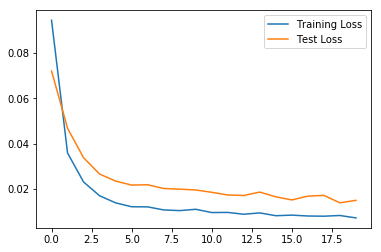

In [109]:
plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Test Loss')
plt.legend()

# Rhode Islander Diarrhea

In [110]:
y = ri['mx']

In [111]:
ri.columns

Index(['Unnamed: 0', 'location_name', 'sex', 'year_id', 'mx', 'lower', 'upper',
       'Climate', 'Rank_x', 'County', 'Population', 'Rank_y',
       'Per capita income', 'Median household income', 'Median family income',
       'Number of households', 'Bristol', 'Kent', 'Newport', 'Providence',
       'Washington',
       'Hot-summer humid continental/Warm-summer humid continental/Oceanic/Humid subtropical',
       'Humid subtropical', 'Oceanic/Humid subtropical',
       'Warm-summer humid continental/Oceanic/Humid subtropical'],
      dtype='object')

In [112]:
ri = ri.drop(columns = ['Unnamed: 0', 'County'])

In [113]:
ri['Per capita income'] = ri['Per capita income'].map(lambda x: int(str(x).replace('$', '').replace(',', '')))

ri['Median household income'] = ri['Median household income'].map(lambda x: int(str(x).replace('$', '').replace(',', '')))

ri['Median family income'] = ri['Median family income'].map(lambda x: int(str(x).replace('$', '').replace(',', '')))

ri['Number of households'] = ri['Number of households'].map(lambda x: int(str(x).replace(',', '')))

In [114]:
ri = ri.rename({'Rank_x': 'Pop_Rank', 'Rank_y': 'Per_Cap_Inc_Rank'}, axis = 1)

In [115]:
sex_dums = pd.get_dummies(ri['sex'])
ri = pd.concat([ri, sex_dums], axis = 1)

ri = ri.drop(columns = ['sex'])

In [116]:
ri.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525 entries, 0 to 524
Data columns (total 25 columns):
location_name                                                                           525 non-null object
year_id                                                                                 525 non-null int64
mx                                                                                      525 non-null float64
lower                                                                                   525 non-null float64
upper                                                                                   525 non-null float64
Climate                                                                                 525 non-null object
Pop_Rank                                                                                525 non-null int64
Population                                                                              525 non-null object
Per_Cap_Inc_Rank              

In [117]:
ri['Population'] = ri['Population'].map(lambda x: int(x.replace(',', '')))

## Linear Regression

In [118]:
indices = ri.loc[ri['year_id'] < 2006].index
ri2 = ri.drop(indices)

In [119]:
test_columns = [col for col in ri2.columns if (col not in ['location_name', 'lower', 'upper',
                                                           'mx', 'Climate'])]
X = ri2[test_columns]
y = ri2['mx']

In [120]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [121]:
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

In [122]:
lr = LinearRegression().fit(X_train_scaled, y_train)

In [123]:
lr.score(X_test_scaled, y_test)

0.7487739519103789

## Random Forest

In [124]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.9350132676709016

## Exploring Correlations

In [129]:
ri.corr()['mx'].nlargest(10)

mx                                                         1.000000
upper                                                      0.982193
lower                                                      0.844211
year_id                                                    0.814758
Bristol                                                    0.163736
Humid subtropical                                          0.163736
Kent                                                       0.115715
Warm-summer humid continental/Oceanic/Humid subtropical    0.115715
Per_Cap_Inc_Rank                                           0.110213
Providence                                                 0.076052
Name: mx, dtype: float64

In [130]:
ri.corr()['mx'].nsmallest(10)

Oceanic/Humid subtropical   -0.290267
Washington                  -0.212714
Newport                     -0.142790
Median household income     -0.131661
Per capita income           -0.124334
Median family income        -0.102927
Female                      -0.052644
Pop_Rank                    -0.023515
Both                        -0.008250
Male                         0.060894
Name: mx, dtype: float64

Year is quite significant here: Rates have risen dramatically in recent years. Climate is moderately correlated here as well: The oceanic and humid subtropical climatic zones (in the southern and southeastern parts of the state) are negatively correlated with the mortality rate, as well as the Washington and Newport counties (which are in the southeast part of the state).

In [138]:
# Let's look at all the counties any _part_ of which is in the relevant climatic zones.
ri['O'] = ri['Climate'].apply(lambda x: int('Oceanic' in x))

In [139]:
ri.corr()['mx']['O']

-0.1637361460134629

In [140]:
ri['HS'] = ri['Climate'].apply(lambda x: int('Humid subtropical' in x))
ri.corr()['mx']['HS']

nan

_Every_ county has a humid subtropical region, so that's why this won't help us here.

## Spatial Correlation

Let's test for spatial correlation among the counties with respect to our mortality rate.

We'll need to build our weight list. Rhode Island is small: The five counties are as follows:

* Bristol borders Providence;

* Kent borders Providence and Washington;

* Newport borders no other county (it's an island);

* Providence borders Bristol and Kent; and

* Washington borders Kent.

We'll again use the simple metric of bordering regions to construct our weights.

In [153]:
W = [('Bristol', {'Providence': 1}), ('Kent', {'Providence': 1, 'Washington': 1}),
     ('Newport', {}), ('Providence', {'Bristol': 1, 'Kent': 1}), ('Washington', {'Kent': 1})]

Let's calculate Moran's I-Statistic by hand. According to wikipedia (https://en.wikipedia.org/wiki/Moran%27s_I),

$$
I = \frac{N}{W}\frac{\Sigma_i\Sigma_jw_{ij}(x_i - \bar{x})(x_j - \bar{x})}{\Sigma_i(x_i - \bar{x})^2}
$$

In our case, we have N = 5, and W = 6. Our matrix looks like:

$$
\begin{matrix}
NA & Bristol & Kent & Newport & Providence & Washington \\
Bristol & 0 & 0 & 0 & 1 & 0 \\
Kent & 0 & 0 & 0 & 1 & 1 \\
Newport & 0 & 0 & 0 & 0 & 0 \\
Providence & 1 & 1 & 0 & 0 & 0 \\
Washington & 0 & 1 & 0 & 0 & 0
\end{matrix}
$$

Let's figure out the other values.

In [178]:
ri2['mx'].mean()

4.405754459081636

In [177]:
ri2.groupby('location_name').mean()

,year_id,mx,lower,upper,Pop_Rank,Population,Per_Cap_Inc_Rank,Per capita income,Median household income,Median family income,...,Newport,Providence,Washington,Hot-summer humid continental/Warm-summer humid continental/Oceanic/Humid subtropical,Humid subtropical,Oceanic/Humid subtropical,Warm-summer humid continental/Oceanic/Humid subtropical,Both,Female,Male
location_name,,,,,,,,,,,,,,,,,,,,,
BristolCounty,2010,5.708823,1.612003,7.784781,5,48912,2,35588,68333,87781,...,0,0,0,0,1,0,0,0.333333,0.333333,0.333333
KentCounty,2010,5.472608,1.651712,7.059320,2,163760,4,31221,61088,77100,...,0,0,0,0,0,0,1,0.333333,0.333333,0.333333
NewportCounty,2010,3.047632,0.898432,4.254748,4,83460,1,36994,67239,82477,...,1,0,0,0,0,1,0,0.333333,0.333333,0.333333
ProvidenceCounty,2010,5.286852,1.617396,6.510760,1,637357,5,25169,48500,61265,...,0,1,0,1,0,0,0,0.333333,0.333333,0.333333
WashingtonCounty,2010,2.512859,0.786261,3.488521,3,126150,3,34737,70285,87999,...,0,0,1,0,0,1,0,0.333333,0.333333,0.333333


So our calculation will be:

$$
I = \frac{5}{6}\frac{2(5.709 - 4.406)(5.287 - 4.406) + 2(5.473 - 4.406)(5.287 - 4.406) + 2(5.473 - 4.406)(2.513 - 4.406)}{(5.709 - 4.406)^2 + (5.473 - 4.406)^2 + (3.048 - 4.406)^2 + (5.287 - 4.406)^2 + (2.513 - 4.406)^2} \\
= 0.01256
$$

Since this is near zero, there's no real correlation here.

## Neural Network

In [168]:
model = Sequential()
model.add(Dense(10, activation = 'relu', input_dim = X_train.shape[1]))
model.add(Dense(5, activation = 'relu'))
model.add(Dense(1))

In [172]:
model.compile(loss = 'mean_squared_error', optimizer = 'adam')

In [173]:
history = model.fit(X_train_scaled, y_train, validation_data = (X_test_scaled, y_test), epochs = 50, batch_size = 16)

Train on 101 samples, validate on 34 samples
Epoch 1/50
101/101 [==============================] - 0s 3ms/step - loss: 6.9699 - val_loss: 7.2959
Epoch 2/50
101/101 [==============================] - 0s 190us/step - loss: 6.7067 - val_loss: 7.0847
Epoch 3/50
101/101 [==============================] - 0s 151us/step - loss: 6.4515 - val_loss: 6.8812
Epoch 4/50
101/101 [==============================] - 0s 197us/step - loss: 6.2048 - val_loss: 6.6803
Epoch 5/50
101/101 [==============================] - 0s 192us/step - loss: 5.9592 - val_loss: 6.4824
Epoch 6/50
101/101 [==============================] - 0s 176us/step - loss: 5.7355 - val_loss: 6.2667
Epoch 7/50
101/101 [==============================] - 0s 189us/step - loss: 5.5054 - val_loss: 6.0123
Epoch 8/50
101/101 [==============================] - 0s 168us/step - loss: 5.2560 - val_loss: 5.7470
Epoch 9/50
101/101 [==============================] - 0s 192us/step - loss: 5.0149 - val_loss: 5.4955
Epoch 10/50
101/101 [==================

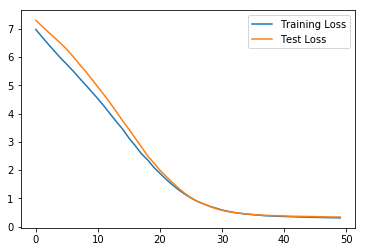

In [174]:
plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Test Loss')
plt.legend()